# Machine Learning Model to predict Arabic dialects

### First, let's import the data that is already cleaned.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report,f1_score
from sklearn.linear_model import SGDClassifier,RidgeClassifier
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.pipeline import Pipeline
from joblib import dump,load
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from sklearn import svm
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestClassifier

In [2]:
train = pd.read_csv("../input/clean-dialect-text/train.csv",lineterminator='\n')
val = pd.read_csv("../input/clean-dialect-text/validation.csv",lineterminator='\n')
test = pd.read_csv("../input/clean-dialect-text/test.csv",lineterminator='\n')

In [3]:
full_test = pd.concat([val,test],ignore_index = True)
classes = train['dialect'].unique()

### Helper Functions

In [4]:
def eval_model(model,X_train,y_train,X_test,y_test):
    
    pred_y_train = model.predict(X_train)
    pred_y_test = model.predict(X_test)
    # choosing macro because I want to give equal importance for all classes
    print("On the Trainig data: ")
    print("F1 Score = ", f1_score(y_train, pred_y_train,average='macro'))
    #print(confusion_matrix(y_train, pred_y_train))
    print(classification_report(y_train, pred_y_train))
    print("######################### ")
    print("On test data: ")
    print("F1 Score = ", f1_score(y_test, pred_y_test,average='macro'))
    #print(confusion_matrix(y_test, pred_y_test))
    print(classification_report(y_test, pred_y_test))
    plt.figure(figsize = (20,25))
    mat = (confusion_matrix(y_test,pred_y_test)).T
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)

    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()
    

# Trying different models.

Choosing the models based on reading through the docs of sklearn and a little of personal experience. For example in SVC docs it's mentioned that SGD and LinearSVC is better for large datasets like our data.

Choosing the processing techniques is based on trail and error and also a little personal experience, I'll go with TFIDF transformer after count vectorizer for all models. 

## 1- SGD classifier

#### a- Making the pipeline

In [5]:
clf_SGD = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,3))),
    #('vect',TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='word',ngram_range=(1, 2), max_features =10000)),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier(alpha=1e-5, 
                      max_iter=20, 
                      class_weight='balanced',
                      penalty= 'l2',
                      verbose=False)),
])



In [6]:
clf_SGD.fit(train['clean_text'],train['dialect'])


Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=1e-05, class_weight='balanced',
                               max_iter=20, verbose=False))])

#### b- Evaluating the model

On the Trainig data: 
F1 Score =  0.9703023275999431
              precision    recall  f1-score   support

          AE       0.99      0.97      0.98     21037
          BH       0.99      0.98      0.98     21031
          DZ       0.95      0.97      0.96     12943
          EG       0.95      0.97      0.96     46106
          IQ       0.95      0.99      0.97     12397
          JO       0.99      0.97      0.98     22329
          KW       0.99      0.98      0.98     33685
          LB       0.95      0.99      0.97     22092
          LY       0.99      0.97      0.98     29197
          MA       0.93      0.98      0.96      9230
          OM       0.98      0.98      0.98     15292
          PL       0.99      0.95      0.97     34990
          QA       0.97      0.98      0.97     24854
          SA       0.98      0.98      0.98     21463
          SD       0.94      0.97      0.95     11546
          SY       0.98      0.96      0.97     12991
          TN       0.91     

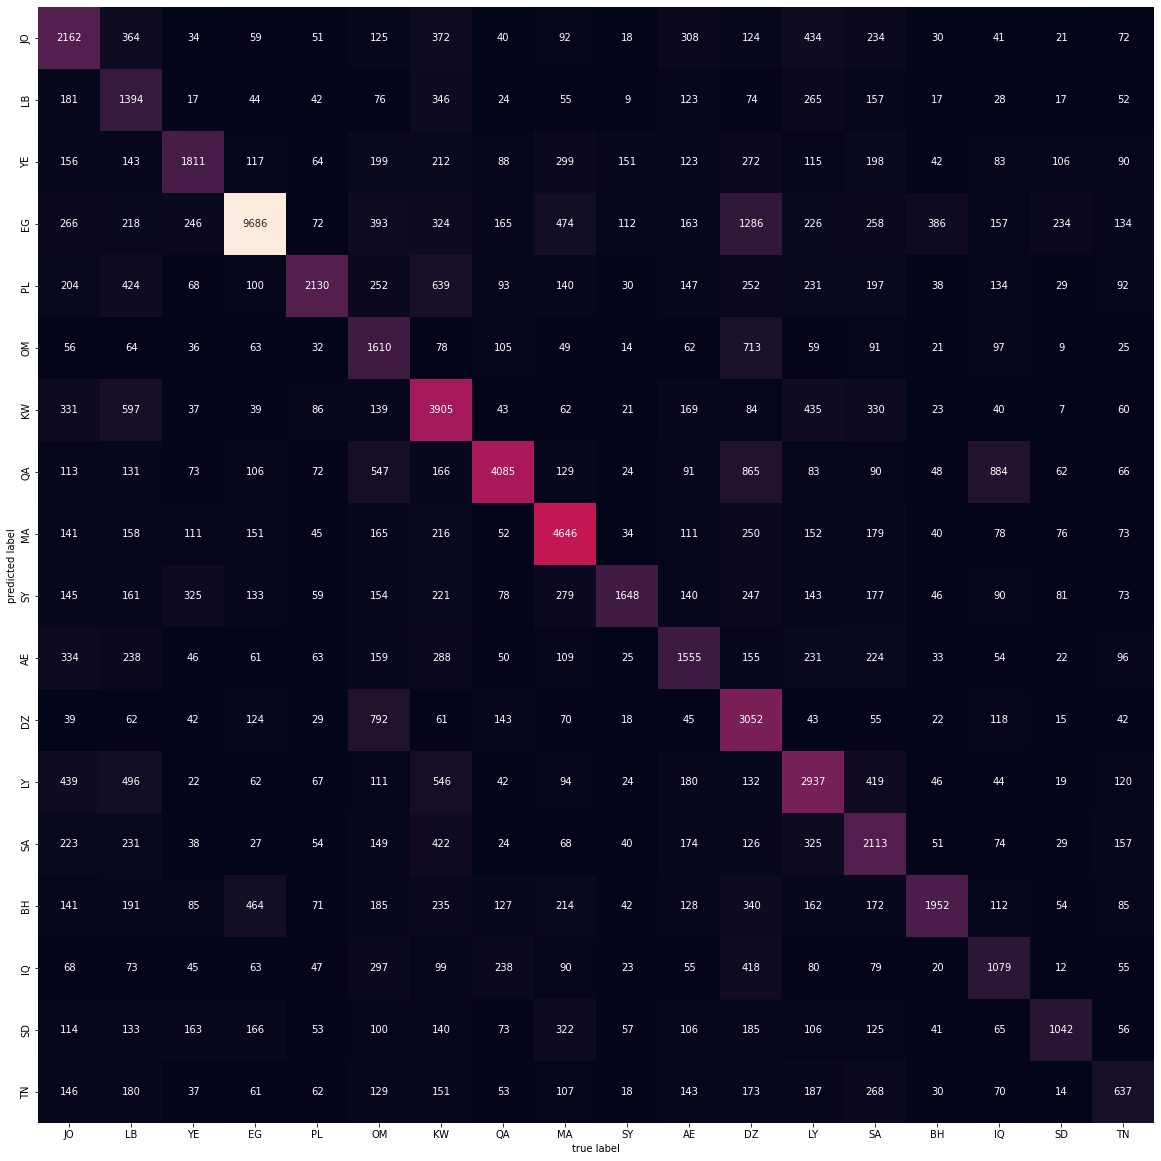

In [7]:
eval_model(clf_SGD,train['clean_text'],train['dialect'],full_test['clean_text'],full_test['dialect'])

## 2- RidgeClassifier

In [8]:
clf_Ridge = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,3))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', RidgeClassifier()),
])


In [9]:
clf_Ridge.fit(train['clean_text'],train['dialect'])

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()), ('clf', RidgeClassifier())])

On the Trainig data: 
F1 Score =  0.9965211229858403
              precision    recall  f1-score   support

          AE       1.00      0.99      1.00     21037
          BH       1.00      1.00      1.00     21031
          DZ       1.00      0.99      1.00     12943
          EG       0.99      1.00      0.99     46106
          IQ       1.00      1.00      1.00     12397
          JO       1.00      1.00      1.00     22329
          KW       1.00      1.00      1.00     33685
          LB       1.00      1.00      1.00     22092
          LY       1.00      1.00      1.00     29197
          MA       1.00      0.99      1.00      9230
          OM       1.00      1.00      1.00     15292
          PL       1.00      1.00      1.00     34990
          QA       1.00      1.00      1.00     24854
          SA       1.00      1.00      1.00     21463
          SD       1.00      0.99      1.00     11546
          SY       1.00      1.00      1.00     12991
          TN       1.00     

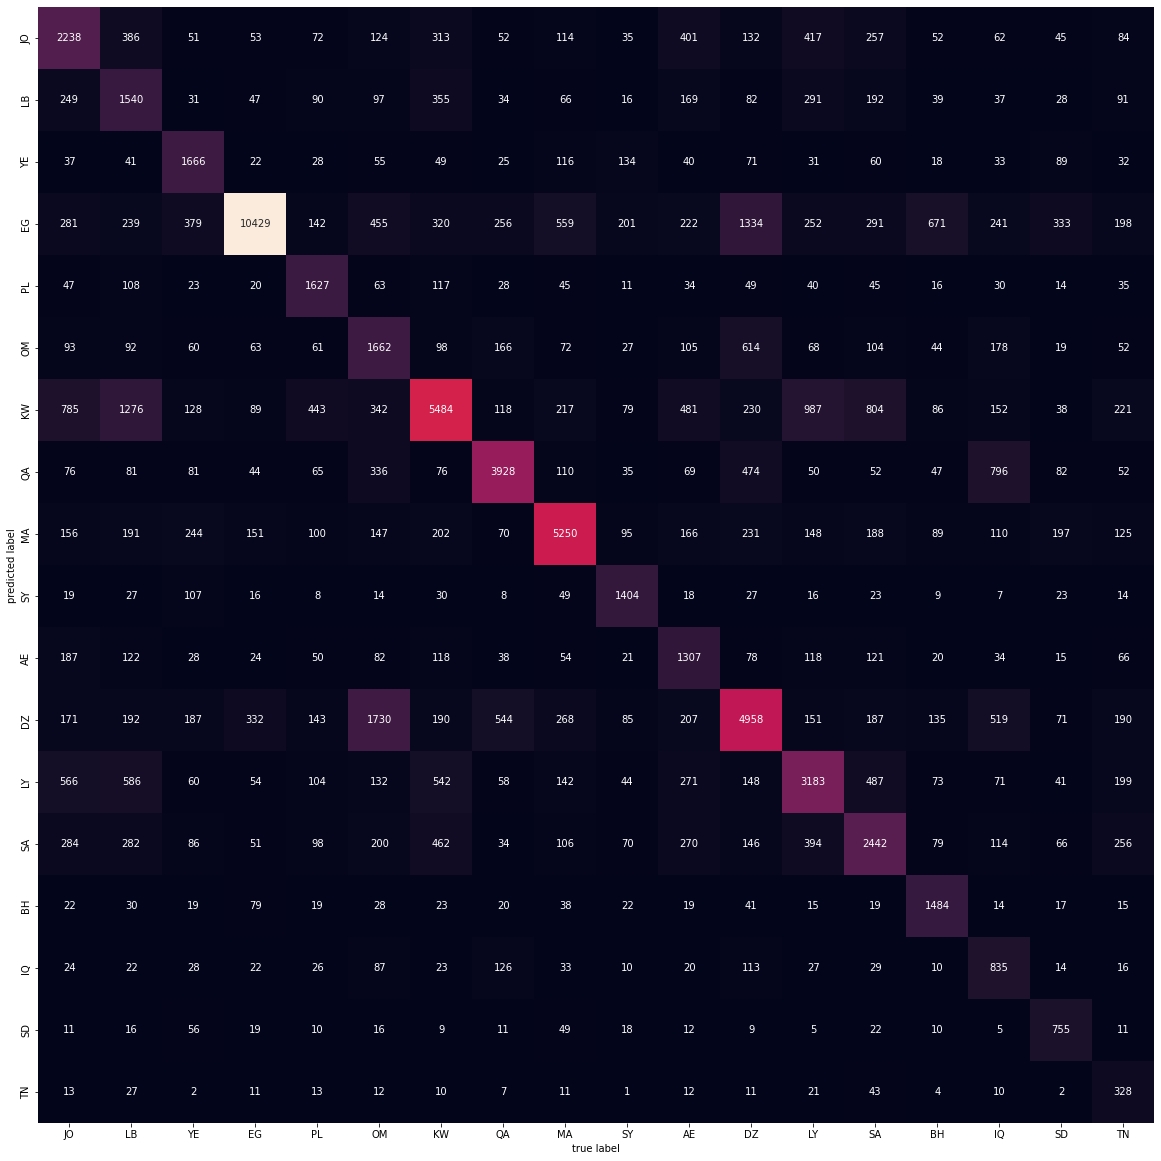

In [10]:
eval_model(clf_Ridge,train['clean_text'],train['dialect'],full_test['clean_text'],full_test['dialect'])

### 3- LinearSVC

In [11]:
clf_SVC = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    #('nyo', Nystroem(gamma=.2, random_state=1,n_components=300)),
    ('clf', svm.LinearSVC(class_weight="balanced",C=0.8)),
])

In [12]:
clf_SVC.fit(train['clean_text'],train['dialect'])

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(C=0.8, class_weight='balanced'))])

On the Trainig data: 
F1 Score =  0.9962941030862811
              precision    recall  f1-score   support

          AE       1.00      1.00      1.00     21037
          BH       1.00      1.00      1.00     21031
          DZ       0.99      1.00      1.00     12943
          EG       0.99      1.00      1.00     46106
          IQ       1.00      1.00      1.00     12397
          JO       1.00      0.99      1.00     22329
          KW       1.00      0.99      1.00     33685
          LB       1.00      1.00      1.00     22092
          LY       1.00      1.00      1.00     29197
          MA       1.00      1.00      1.00      9230
          OM       0.99      1.00      1.00     15292
          PL       1.00      0.99      0.99     34990
          QA       1.00      1.00      1.00     24854
          SA       1.00      1.00      1.00     21463
          SD       1.00      1.00      1.00     11546
          SY       0.99      1.00      1.00     12991
          TN       0.99     

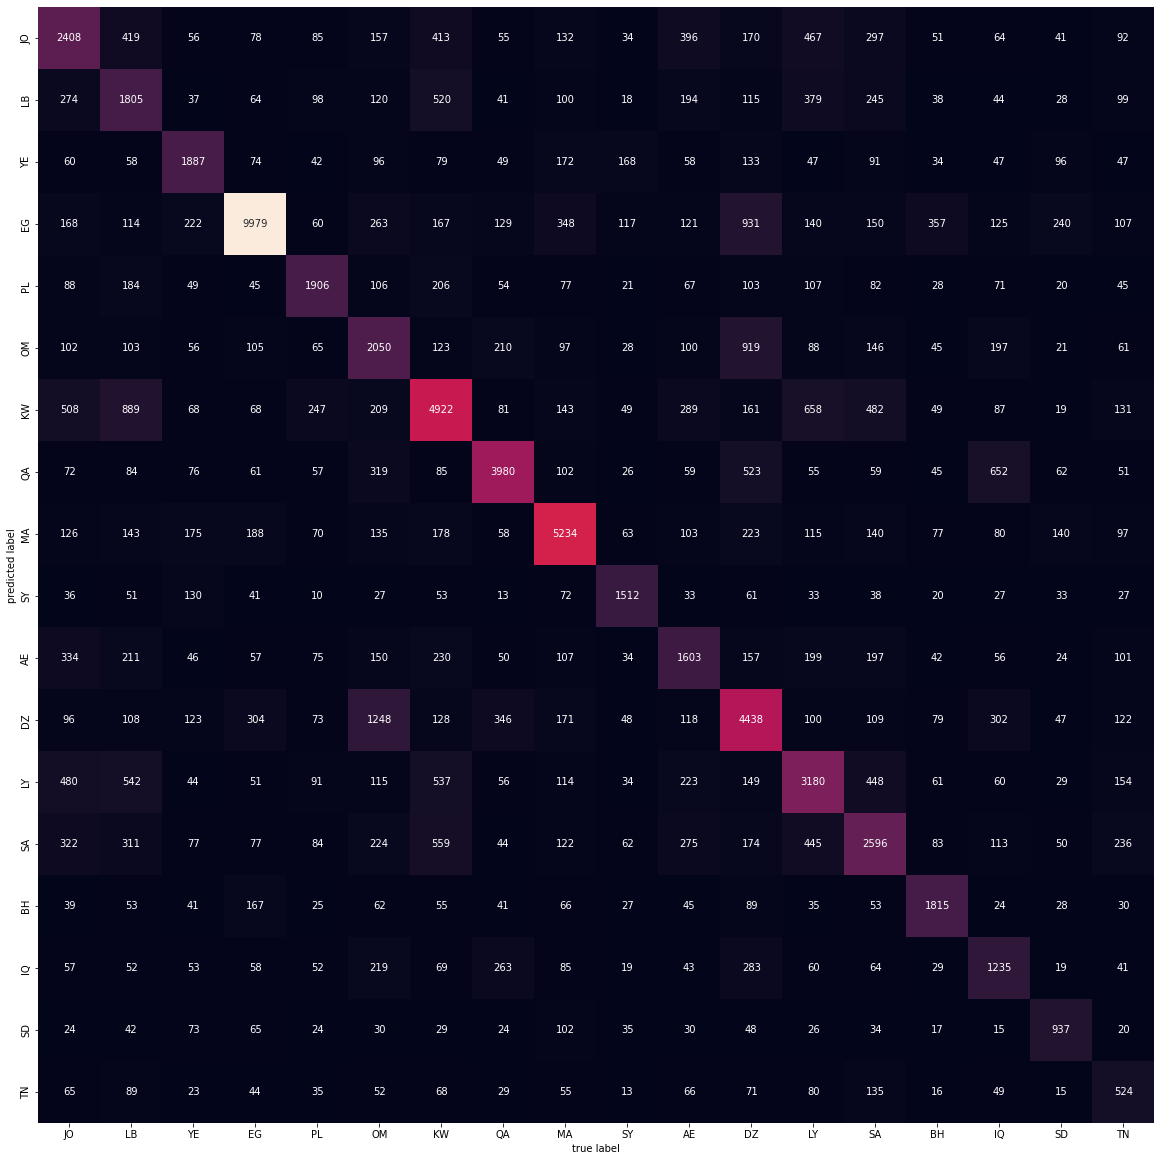

In [13]:
eval_model(clf_SVC,train['clean_text'],train['dialect'],full_test['clean_text'],full_test['dialect'])

# Saving the choosen model

I'll choose linearSVC as final model

In [14]:
#dump(clf_SVC,'SVCModel.joblib')


In [15]:
import pickle

pickle.dump(clf_SVC, open('SVCModel', 'wb'))

## conclusion:

- The models usually classify Algerain dialect as egyptain, I checked for some misclassified examples myself and I can understand why the model is confused.
- Arabic dialects are very similar! we can't count only on text to see the difference.
- Maybe LSTM will be a good because some sentences have only one word that refer to certain dialect.
- Maybe with more RAM we'll get better results after applying RandomizedSearch, But I believe that the most we can get is 60%.